# Monthly profits (y-axis) vs Quarterly Real GDP per Capita (x-axis) by scatter plot using Alphavantage API

## Question
Do Quarterly Real GDP per Capita affect the monthly profit of NASDAQ-100 (NDX) Index?

## Null hypothesis
Quarterly Real GDP per Capita does not affect the monthly profit of NDX.

## Analysis
- The **Pearson’s correlation coefficient** between the Real GDP per Capita and the monthly profit of NDX is **0.21**. This value indicates a **very weak or negligible correlation**, as it falls below the threshold of **0.3** for a meaningful relationship. Consequently, we can infer that there is **no significant correlation** between these two variables.

- The **p-value** associated with this correlation is **0.04**. Since this value is below the common significance level of **0.05**, it indicates that the observed data are inconsistent with the null hypothesis. In this case, we have strong evidence to reject the null hypothesis in favor of the alternative hypothesis.

- The **coefficient of determination (r-squared)**, which quantifies the proportion of variance in NDX profits explained by the GDP per Capita, is **0.04**. This low value suggests that the linear relationship between these variables is **minimal** or **nonexistent**.

- In summary, while we find no significant correlation between Real GDP per Capita and NDX monthly profits. However, it can't be said that the the Quarterly Real GDP per Capita does not affect the monthly profit of NDX at all. To gain deeper insights, consider conducting additional studies that explore other macroeconomic indicators and their potential relationships with stock market performance.

In [1]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
import scipy.stats as st
from scipy.stats import linregress
from pprint import pprint

# Import the API key
from api_keys import bls_api_key, alpha_vantage_api_key

# Turn off warning messages
import warnings
warnings.filterwarnings("ignore")

#### Optional: Ticker Check 

In [2]:
# # Set base url
# base_url = 'https://www.alphavantage.co/query?'

# # Set parameters
# function = 'SYMBOL_SEARCH'
# keywords = input('Enter your search: ')
# apikey = alpha_vantage_api_key

# # Create parameter dictionary
# params = {'function': function,
#           'keywords': keywords,
#           'apikey': apikey}

# # Run a request and return response
# response = requests.get(base_url, params=params)

# # Convert response to json
# response_json = response.json()
# response_json

# Part 1: Find Monthly Stock Profit of ticker
**Note: Monthly profits is defined by the stock price at 'close' of the month minus stock price at 'Open' of the month.**

### Alpha Vantage
Reference https://www.alphavantage.co/documentation/#monthly.

### Ticker symbol QQQ
Reference https://www.nasdaq.com/market-activity/etf/qqq. This is based on NASDAQ-100 index.

In [3]:
# Set base url
base_url = 'https://www.alphavantage.co/query?'

# Set parameters
function = 'TIME_SERIES_MONTHLY'
symbol = 'QQQ'
apikey = alpha_vantage_api_key

# Create parameter dictionary
params = {'function': function,
          'symbol': symbol,
          'apikey': apikey}

# Run a request and return response
response = requests.get(base_url, params=params)

# Convert response to json
response_json = response.json()

In [4]:
# Create an empty list to store stock price
ticker_prices = []

# Loop through the list of price data and store in a list
ticker_price = response_json['Monthly Time Series']

# Iterate key-value pairs of the list
for date, value in ticker_price.items():
    
    ticker_prices.append({'Date': date,
                          'Open': value['1. open'],
                          'Close': value['4. close']})

# Create data frame based on collected list
ticker_df = pd.DataFrame(ticker_prices)

# Convert Date columnb type from object to datetime
ticker_df['Date'] = pd.to_datetime(ticker_df['Date'], format='%Y-%m-%d')

# Convert profit column from object to float and into unit (millions)
ticker_df['Open'] = ticker_df['Open'].astype(float)
ticker_df['Close'] = ticker_df['Close'].astype(float)

# Create new columns for data frame
# Extract year and month
ticker_df['Year'] = ticker_df['Date'].dt.year
ticker_df['Month'] = ticker_df['Date'].dt.month
ticker_df['Monthly Profits'] = ticker_df['Close'] - ticker_df['Open']

# Convert month from integer to string
ticker_df['Month'] = pd.to_datetime(ticker_df['Month'].astype(str), format='%m').dt.month_name()

# Remove irrelevant columns
ticker_df = ticker_df.loc[:, ['Year', 'Month', 'Monthly Profits']]

# Part 2: Find US Real GDP per Capita
This API returns the quarterly Real GDP per Capita data of the United States.

In [5]:
# Set base url
base_url = 'https://www.alphavantage.co/query?'

# Set parameters
function = 'REAL_GDP_PER_CAPITA'
apikey = alpha_vantage_api_key

# Create parameter dictionary
params = {'function': function,
          'apikey': apikey}

# Run a request and return response
response = requests.get(base_url, params=params)

# Convert response to json
response_json = response.json()

In [6]:
# Create data frame
gdp_df = pd.DataFrame(response_json['data'])

# Convert Date columnb type from object to datetime
gdp_df['date'] = pd.to_datetime(gdp_df['date'], format='%Y-%m-%d')

# Convert value column from object to float
gdp_df['value'] = gdp_df['value'].astype(float)

# Create new columns for data frame
# Extract year and month
gdp_df['Year'] = gdp_df['date'].dt.year
gdp_df['Month'] = gdp_df['date'].dt.month

# Convert month from integer to string
gdp_df['Month'] = pd.to_datetime(gdp_df['Month'].astype(str), format='%m').dt.month_name()

# Remove irrelevant columns
gdp_df = gdp_df.loc[:, ['Year', 'Month', 'value']]

# Part 3: Merge Data Frames and Plot

The r-squared is: 0.0437
The p-value is: 0.04
The correlation between both factors is 0.21


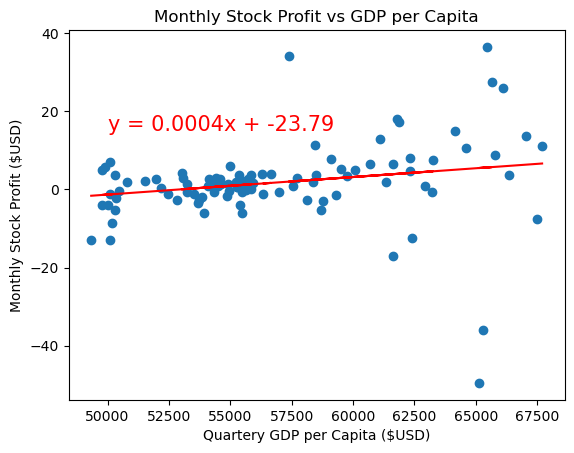

In [7]:
# Combine both data frames
combined_df = pd.merge(gdp_df, ticker_df, how='inner', on=['Year','Month'])

# Add the linear regression equation and line to plot
x_values = combined_df['value']
y_values = combined_df['Monthly Profits']
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,4)) + "x + " + str(round(intercept,2))
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")

# Adjust the annotated location as required
plt.annotate(line_eq,(50000,15),fontsize=15,color="red")
plt.xlabel('Quartery GDP per Capita ($USD)')
plt.ylabel('Monthly Stock Profit ($USD)')
plt.title(f'Monthly Stock Profit vs GDP per Capita')

# Print the r squared value
print(f"The r-squared is: {round(rvalue**2, 4)}")
print(f"The p-value is: {round(pvalue, 4)}")

# The next example will compute the Pearson correlation coefficient between "Same Month Stock Profits" and "Unemployment Rate"
correlation = st.pearsonr(x_values,y_values)
print(f"The correlation between both factors is {round(correlation[0],2)}")

# Save the figure
plt.savefig('output_data/14.Monthly_Profit_GDP_Graph.png')

# Show plot
plt.show()